# Project 2 - Supervised Learning

### Let's first check the data in the **train.csv**

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
import time

train_data_imbalanced = pd.read_csv('train.csv')


### Let's check if there are columns with missing values
### And change the non-numeric columns to numeric

In [31]:
cols_with_na = train_data_imbalanced.columns[train_data_imbalanced.isna().any()].tolist()
print('Columns with missing values:', cols_with_na)

# train_data['policy_id'] = train_data['policy_id'].apply(lambda x: x.replace('ID', ''))
train_data_imbalanced.drop('policy_id', axis=1, inplace=True)
train_data_imbalanced['area_cluster'] = train_data_imbalanced['area_cluster'].apply(lambda x: x.replace('C', ''))
train_data_imbalanced = pd.get_dummies(train_data_imbalanced,
                            columns=['segment', 'fuel_type', 'engine_type', 'rear_brakes_type', 'steering_type'])
train_data_imbalanced['model'] = train_data_imbalanced['model'].apply(lambda x: x.replace('M', ''))
train_data_imbalanced = train_data_imbalanced.replace({"Yes": True, "No": False})
encoder = LabelEncoder()
train_data_imbalanced['transmission_type'] = encoder.fit_transform(train_data_imbalanced['transmission_type'])

train_data_imbalanced['max_torque'] = train_data_imbalanced['max_torque'].apply(
    lambda s: float(s.split('Nm@')[0]) * float(s.split('Nm@')[1].replace('rpm', '')))
train_data_imbalanced['max_power'] = train_data_imbalanced['max_power'].apply(
    lambda s: float(s.split('bhp@')[0]) * float(s.split('bhp@')[1].replace('rpm', '')))

# Undersampling

claimed = train_data_imbalanced[train_data_imbalanced['is_claim'] == 1]
not_claimed = train_data_imbalanced[train_data_imbalanced['is_claim'] == 0]
sample_size = min(len(claimed), len(not_claimed))
train_data = pd.concat([claimed.sample(n=sample_size), not_claimed.sample(n=sample_size)])

print(train_data.head())
print(len(train_data))


Columns with missing values: []
       policy_tenure  age_of_car  age_of_policyholder area_cluster   
22480       1.018573        0.04             0.413462           10  \
288         0.270751        0.16             0.596154            8   
10219       0.124438        0.07             0.500000           19   
26974       1.108218        0.04             0.442308           14   
45625       1.177326        0.23             0.461538           21   

       population_density  make model  max_torque  max_power  airbags  ...   
22480               73430     1     1    210000.0   242160.0        2  ...  \
288                  8794     3     4    687500.0   453800.0        6  ...   
10219               27742     1     6    497200.0   531000.0        2  ...   
26974                7788     3     4    687500.0   453800.0        6  ...   
45625                3264     3     4    687500.0   453800.0        6  ...   

       engine_type_F8D Petrol Engine  engine_type_G12B   
22480               

As we can see, there are no missing values in our data set

We had to have the same number of claims and not claims to avoid **imbalance**

### Let's now get some more general information of our features

In [32]:
print(train_data.describe())

       policy_tenure   age_of_car  age_of_policyholder  population_density   
count    7496.000000  7496.000000          7496.000000         7496.000000  \
mean        0.673261     0.065180             0.475418        18102.036820   
std         0.408235     0.054053             0.125603        16689.328296   
min         0.002739     0.000000             0.288462          290.000000   
25%         0.277868     0.020000             0.375000         6112.000000   
50%         0.706049     0.050000             0.461538         8794.000000   
75%         1.065146     0.100000             0.548077        27003.000000   
max         1.375988     0.390000             1.000000        73430.000000   

              make     max_torque      max_power      airbags  displacement   
count  7496.000000    7496.000000    7496.000000  7496.000000   7496.000000  \
mean      1.767609  445329.063501  403352.661153     3.140342   1166.263207   
std       1.140624  181396.371141  116188.436034     1.83525

In [33]:
# % matplotlib inline

# sb.pairplot(train_data)

After some investigating, there are no major outliers that require work.
There are some variables that seem to have no correlation with the `is_claim` feature

### Now let's check what features have no correlation with the test feature

We will also create some subsets with:
  - Data witout >= 0.9 correlated data
  - Data witout >= 0.8 correlated data
  - Data witout >= 0.7 correlated data
  - Data correlated with the target feature

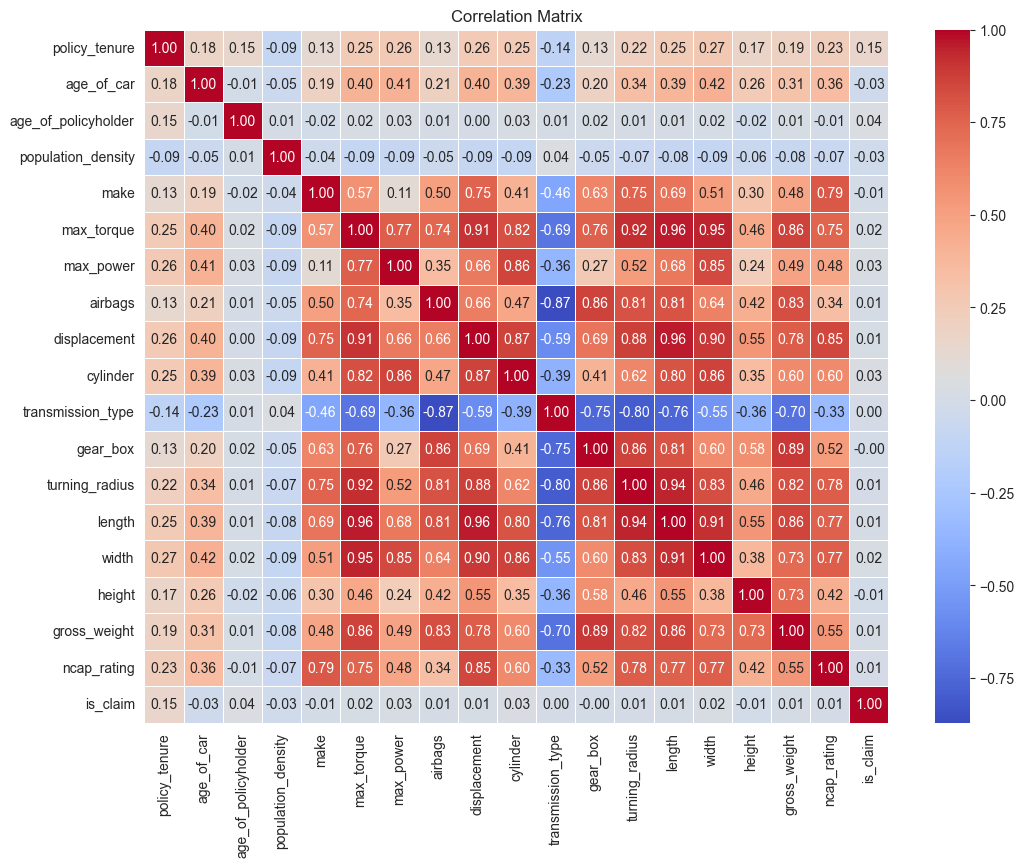

In [34]:

numeric_columns = train_data.select_dtypes(include='number')
train_data_numeric = train_data[numeric_columns.columns]



correlation_matrix = train_data_numeric.corr()

# Creating the subsets without the highly correlated features
corr_cols08 = set()
corr_cols09 = set()
corr_cols07 = set()
nocorr = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if correlation_matrix.columns[i] != correlation_matrix.columns[j] and abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[j]
            corr_cols08.add(colname)

        if correlation_matrix.columns[i] != correlation_matrix.columns[j] and abs(correlation_matrix.iloc[i, j]) > 0.9:
            colname = correlation_matrix.columns[j]
            corr_cols09.add(colname)

        if correlation_matrix.columns[i] != correlation_matrix.columns[j] and abs(correlation_matrix.iloc[i, j]) > 0.7:
            colname = correlation_matrix.columns[j]
            corr_cols07.add(colname)
    if correlation_matrix.columns[i] != "is_claim":
        j = (len(correlation_matrix.columns) - 1)
        if abs((correlation_matrix.iloc[i, j])) < 0.02:
            colname = correlation_matrix.columns[i]
            nocorr.add(colname)

train_data_08 = train_data_numeric.drop(columns=corr_cols08)
train_data_09 = train_data_numeric.drop(columns=corr_cols09)
train_data_07 = train_data_numeric.drop(columns=corr_cols07)
train_data_nocorr = train_data_numeric.drop(columns=nocorr)

train_data.to_csv('fixed_train_data.csv', index=False)
train_data_08.to_csv('fixed_train_data_08.csv', index=False)
train_data_09.to_csv('fixed_train_data_09.csv', index=False)
train_data_07.to_csv('fixed_train_data_07.csv', index=False)
train_data_nocorr.to_csv('fixed_train_data_nocorr.csv', index=False)

plt.figure(figsize=(12, 9))
sb.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

Let's combine some features to create some more:

- Create a new column `combination` that uses the most importante features to the target
- Use some preprocessing tools (Polynomial and Scaler) to create some more features

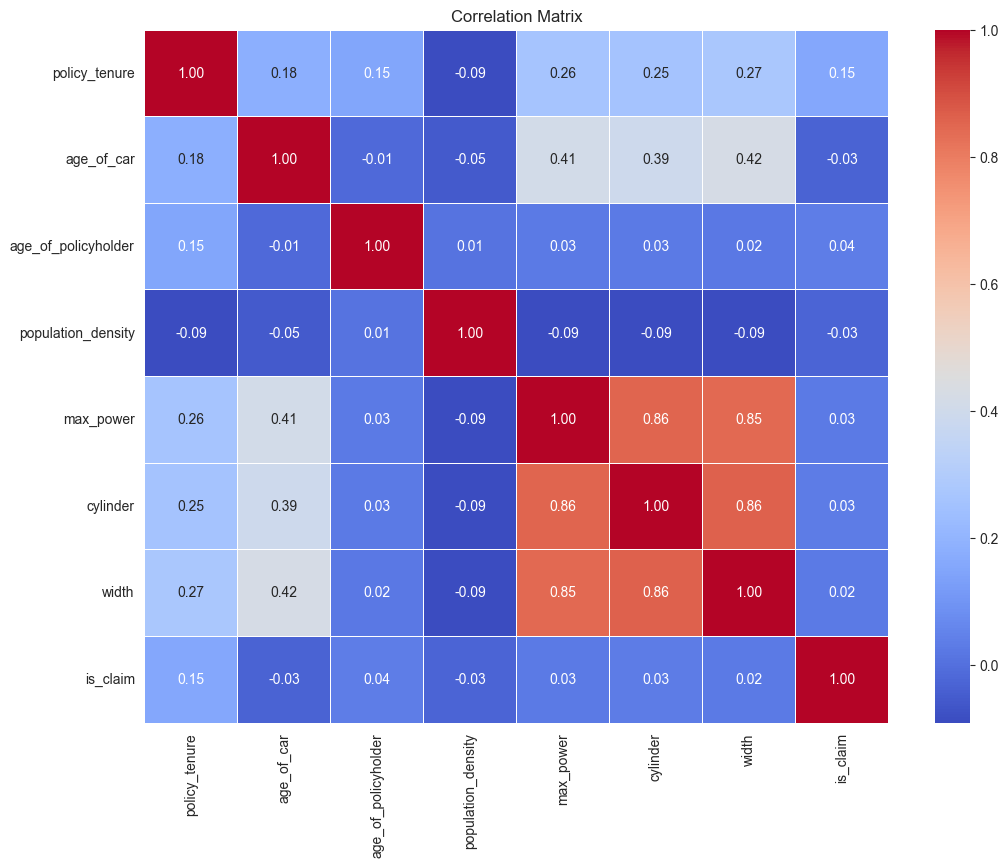

In [35]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Combination feature

#train_data_nocorr.insert(len(train_data_nocorr.columns) - 1, 'combination', train_data_nocorr['policy_tenure'] * train_data_nocorr['age_of_policyholder'] - train_data_nocorr['age_of_car'])

correlation_matrix = train_data_nocorr.corr()

plt.figure(figsize=(12, 9))
sb.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# Polynomial

target = "is_claim"

poly = PolynomialFeatures(degree=2)

X = train_data_nocorr.drop(target, axis=1)
y = train_data_nocorr[target]

X_poly = poly.fit_transform(X)

train_data_poly = pd.concat([pd.DataFrame(X_poly), y], axis=1)


#Scale
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

train_data_scaled = pd.concat([pd.DataFrame(X_scaled), y], axis=1)

#Both

X_poly_scaled = poly.fit_transform(X_scaled)

train_data_poly_scaled = pd.concat([pd.DataFrame(X_poly_scaled), y], axis=1)



### Now we are going to check if there are any non numerical features that have an high impact on the target feature

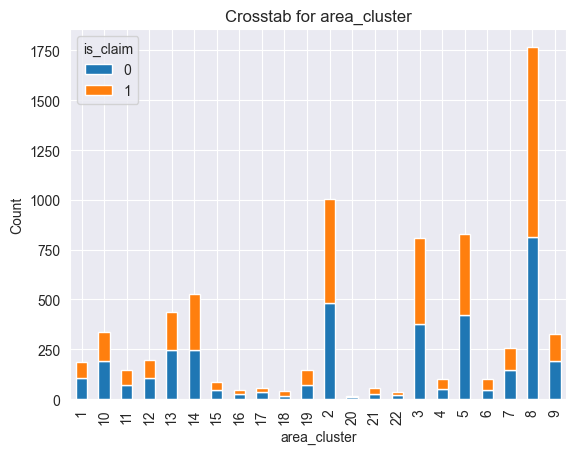

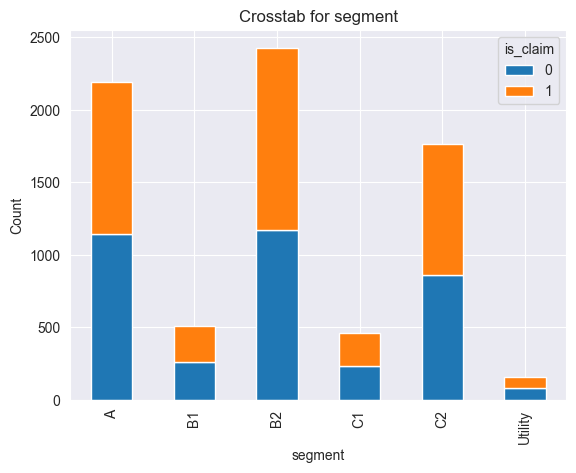

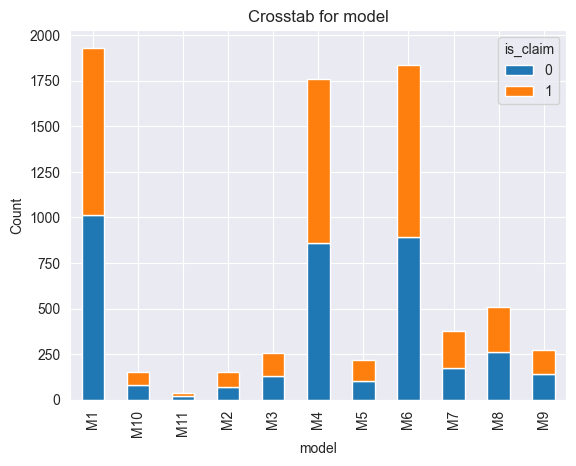

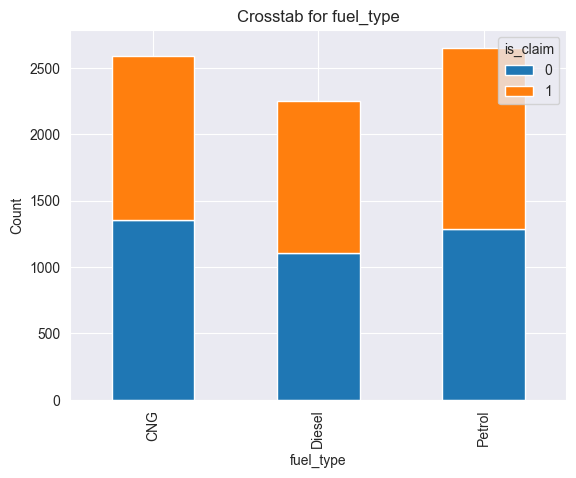

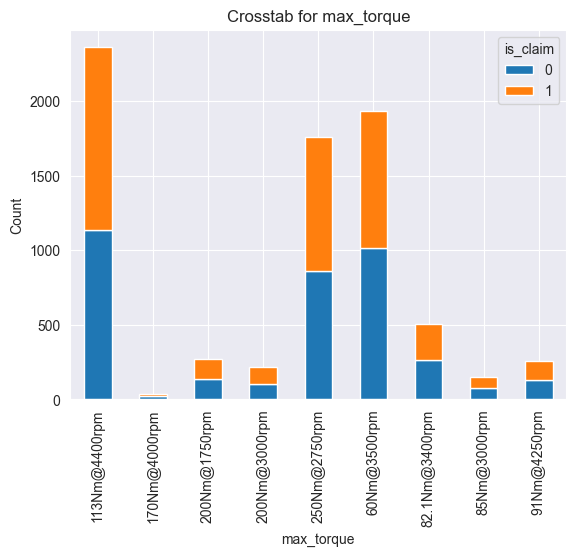

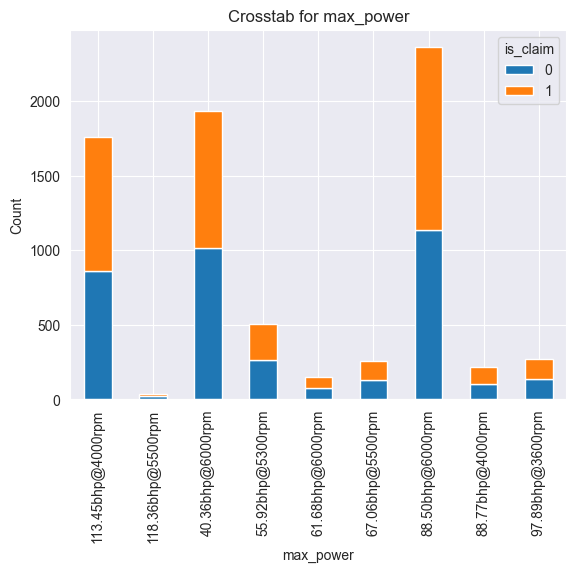

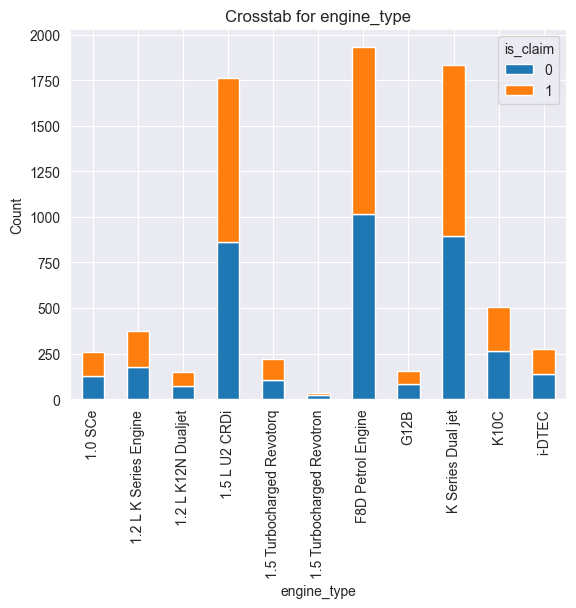

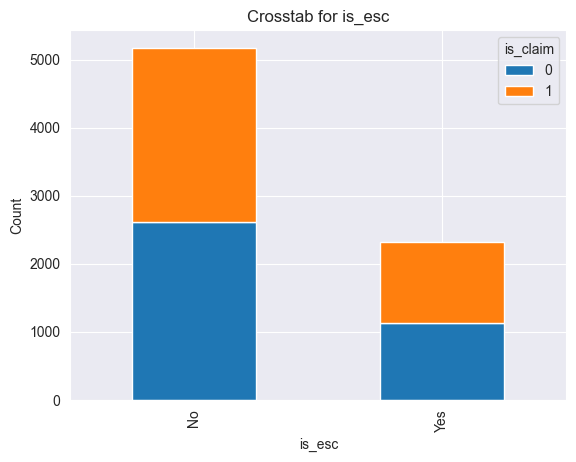

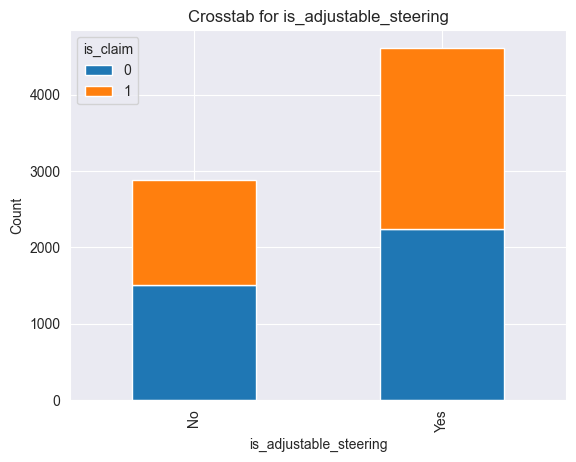

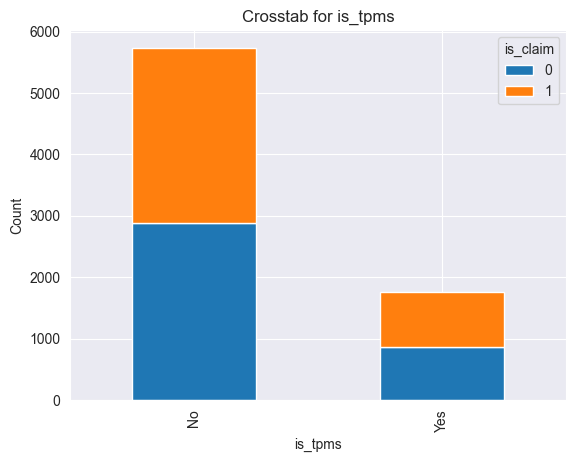

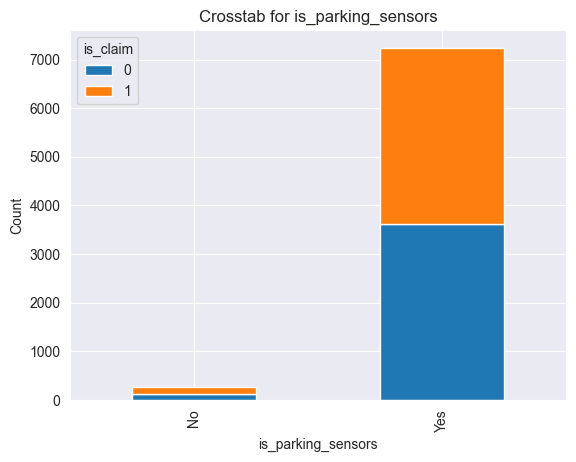

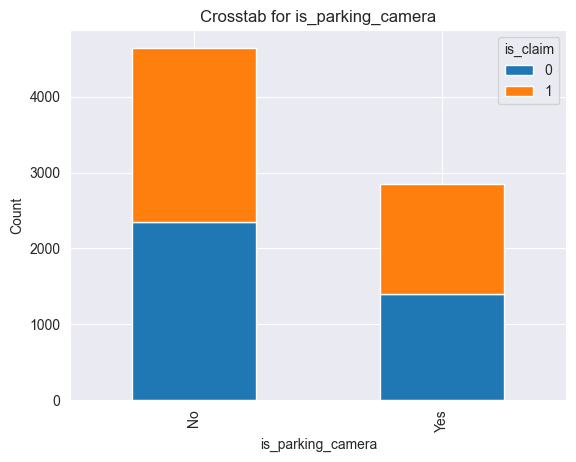

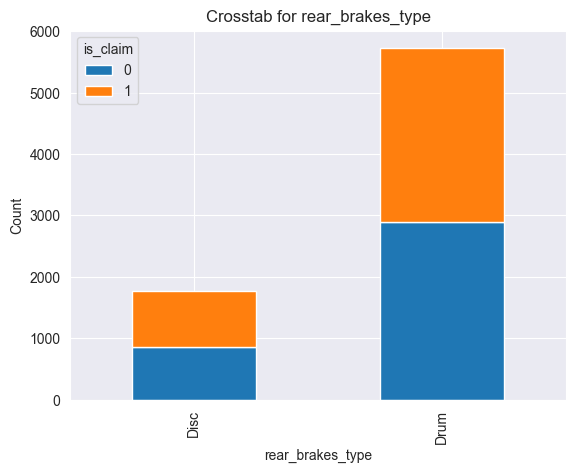

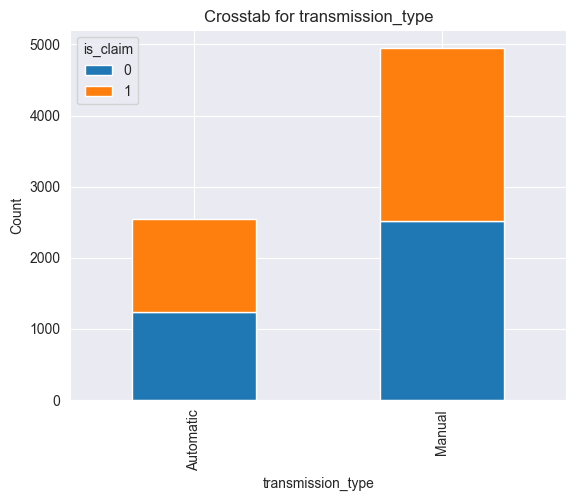

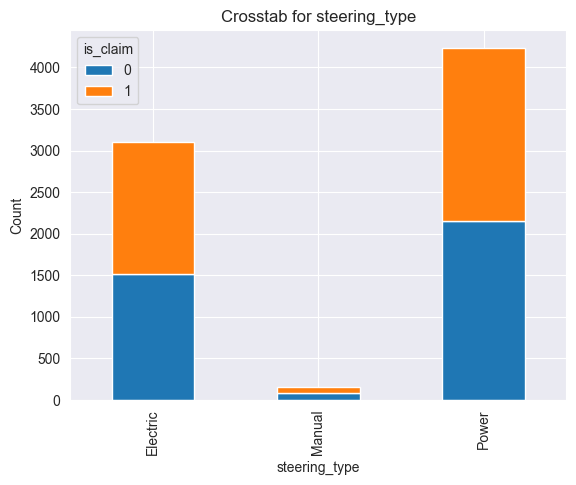

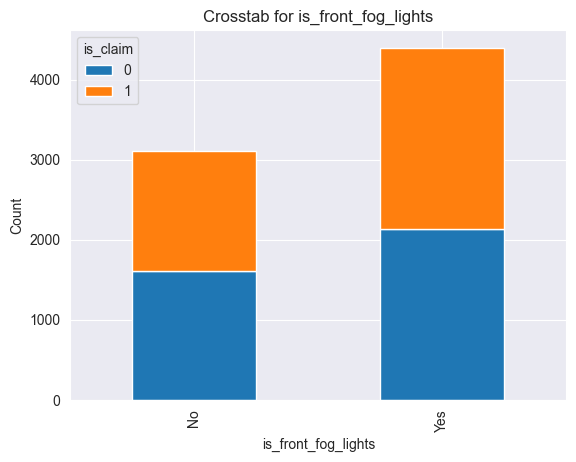

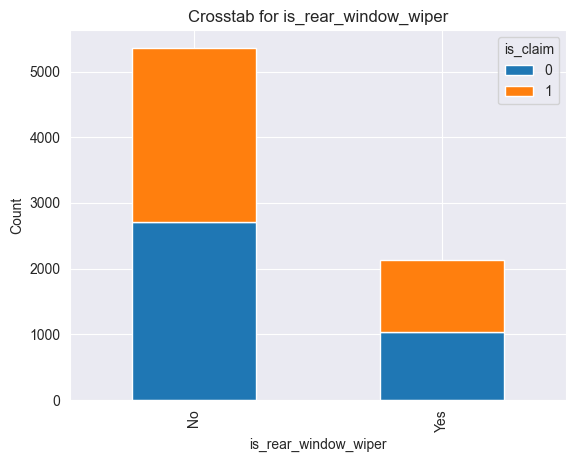

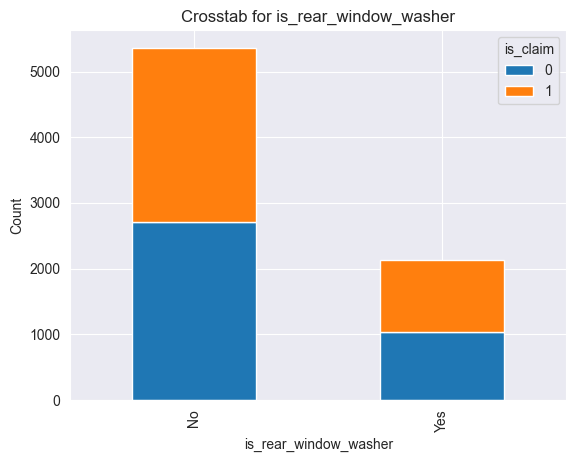

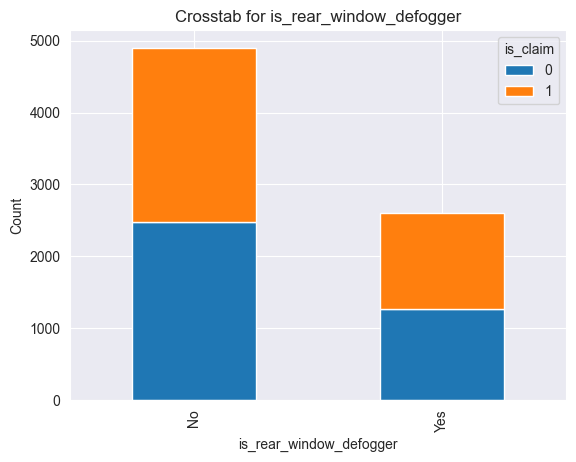

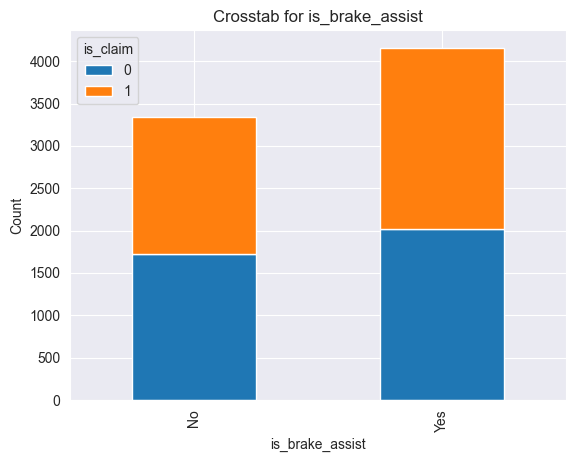

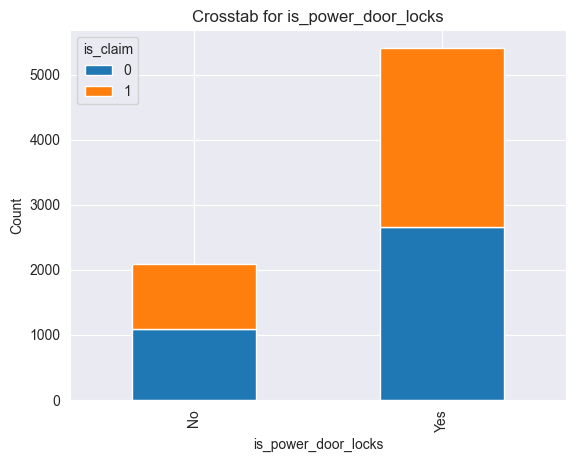

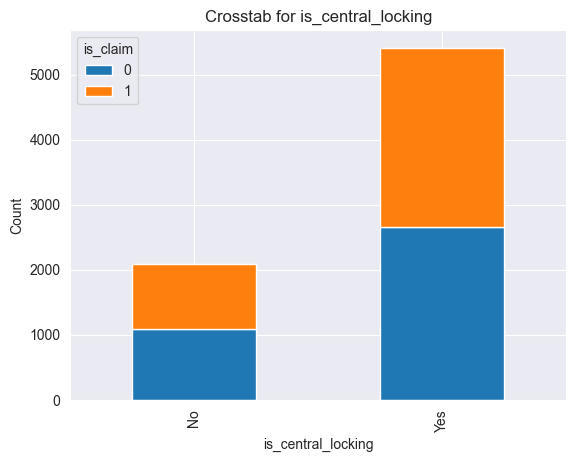

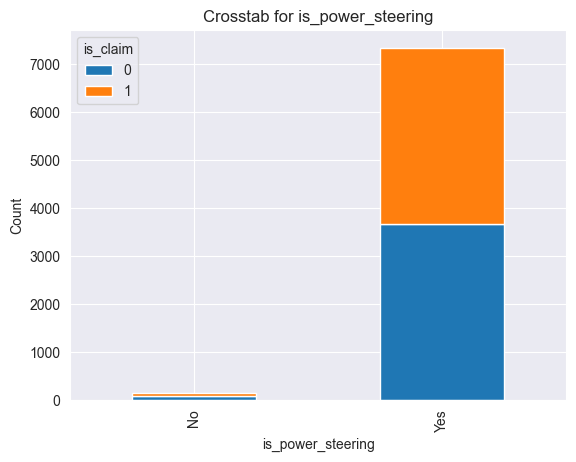

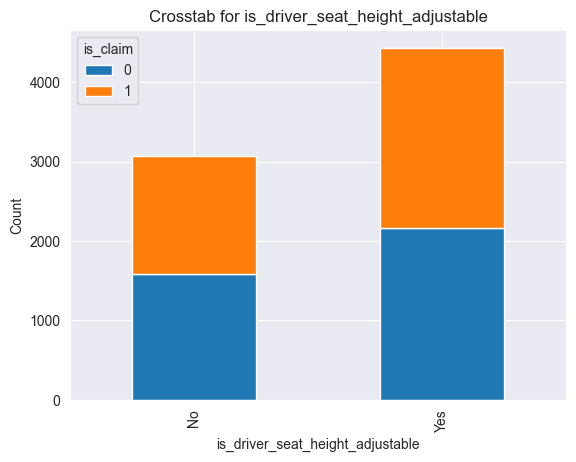

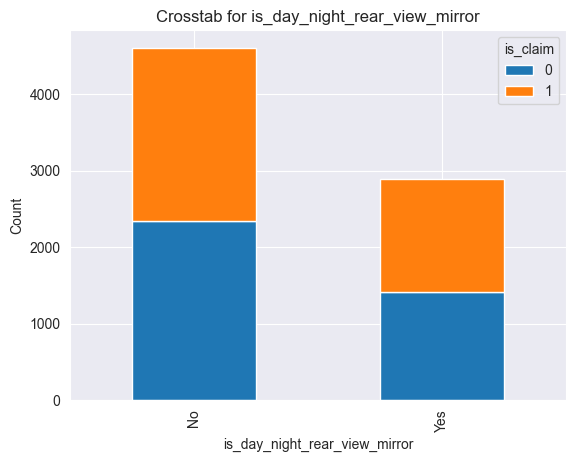

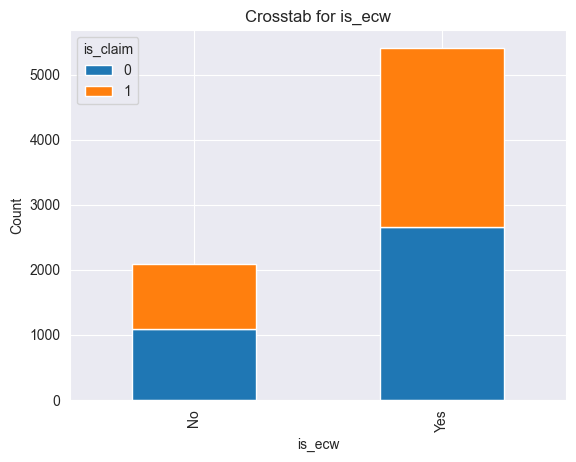

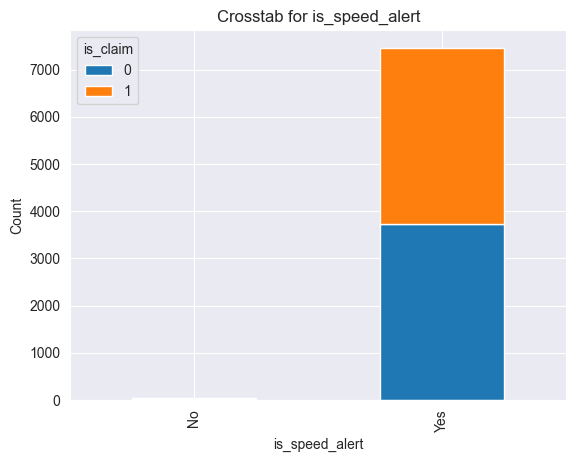

In [26]:
non_numeric_columns = train_data.select_dtypes(exclude='number')

for column in non_numeric_columns:
    if 'id' in column: continue
    crosstab_table = pd.crosstab(train_data[column], train_data['is_claim'])
    crosstab_table.plot(kind='bar', stacked=True)

    plt.title(f'Crosstab for {column}')
    plt.xlabel(column)
    plt.ylabel('Count')

    plt.show()



Numeric features don't correlate with the `is_claim` feature, most probably because it is a binary feature and not a number one.
But there are others features that correlate with each other, which might give more strength to those values, something that we want to avoid.
A good way of avoiding it is to remove the column that correlate too much with another (>= 0.85)

In non-numeric features we didn't get a clear separation but there are some choices that are more favorable. For example in the feature `segment`, people insure more an `A` than a `Utility` value

### Let's now dive into the classifier methods

We have done an initial comparison of all the algorithms

In [36]:
classifiers = {
    'Decision Tree': DecisionTreeClassifier(),
    'Neural Network': MLPClassifier(),
    'K-NN': KNeighborsClassifier(),
    'SVM': SVC()
}
target_column = "is_claim"
X = train_data.drop(target_column, axis=1)
y = train_data[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Numeric features don't correlate with the `is_claim` feature, most probably because it is a binary feature and not a number one.
But there are others features that correlate with each other, which might give more strength to those values, something that we want to avoid.
A good way of avoiding it is to remove the column that correlate too much with another (>= 0.85)

In non-numeric features we didn't get a clear separation but there are some choices that are more favorable. For example in the feature `segment`, people insure more an `A` than a `Utility` value

### Let's now dive into the classifier methods

We have done an initial comparison of all the algorithms

In [37]:
classifiers = {
    'Decision Tree': DecisionTreeClassifier(),
    'Neural Network': MLPClassifier(),
    'K-NN': KNeighborsClassifier(),
    'SVM': SVC()
}
target_column = "is_claim"
X = train_data_imbalanced.drop(target_column, axis=1)
y = train_data_imbalanced[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        Classifier              Confusion Matrix  Precision    Recall   
0    Decision Tree  [[15143, 1274], [1047, 114]]   0.878978  0.867960  \
1    Decision Tree  [[15208, 1209], [1052, 109]]   0.878988  0.871373   
2    Decision Tree  [[15140, 1277], [1055, 106]]   0.878173  0.867334   
3    Decision Tree  [[15131, 1286], [1053, 108]]   0.878302  0.866936   
4    Decision Tree  [[15149, 1268], [1050, 111]]   0.878730  0.868131   
5   Neural Network       [[16417, 0], [1161, 0]]   0.938314  0.933952   
6   Neural Network       [[16417, 0], [1161, 0]]   0.938314  0.933952   
7   Neural Network       [[16417, 0], [1161, 0]]   0.938314  0.933952   
8   Neural Network       [[16417, 0], [1161, 0]]   0.938314  0.933952   
9   Neural Network       [[16417, 0], [1161, 0]]   0.938314  0.933952   
10            K-NN      [[16366, 51], [1155, 6]]   0.879337  0.931392   
11            K-NN      [[16366, 51], [1155, 6]]   0.879337  0.931392   
12            K-NN      [[16366, 51], [1155, 6]]   

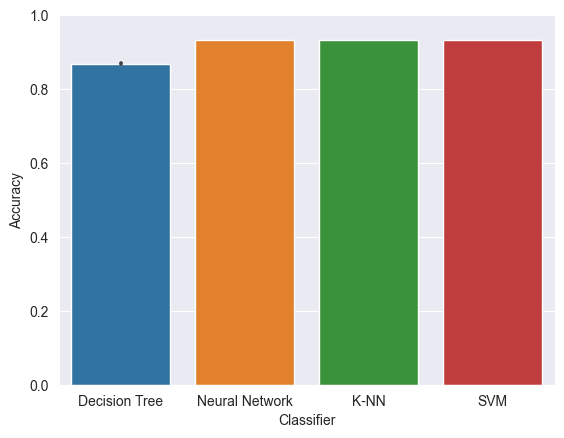

In [38]:
# Train and evaluate the classifiers
results = []

for (name, classifier) in classifiers.items():

    for _ in range(5):
        # Train the model
        start_time = time.time()
        classifier.fit(X_train, y_train)
        train_time = time.time() - start_time

        # Test the model
        start_time = time.time()
        y_pred = classifier.predict(X_test)
        test_time = time.time() - start_time

        # Calculate evaluation metrics
        conf_matrix = confusion_matrix(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
        recall = recall_score(y_test, y_pred, average='weighted')
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')

        # Store the results
        results.append({
            'Classifier': name,
            'Confusion Matrix': conf_matrix,
            'Precision': precision,
            'Recall': recall,
            'Accuracy': accuracy,
            'F1 Score': f1,
            'Train Time': train_time,
            'Test Time': test_time
        })
# Convert the results into a DataFrame
results_df = pd.DataFrame(results)

# Display the results
print(results_df)

plt.ylim(0, 1)
sb.barplot(x='Classifier', y='Accuracy', data=results_df)
plt.show()

As we can see in the confusion matrix, we are having very high accuracies because our model is only predicting `No`. This is the reason we **undersampled**

### Neural Network

Until now we have only used the default data and model settings.
We are now going to tweak those settings and values to try to get the best results possible.

We tested 8 sets:

- Default Set
- Set without more than 90% correlated information
- Set without more than 80% correlated information
- Set without more than 70% correlated information
- Only data that is correlated to the target feature
- Polynomial feature data
- Scaled feature data
- Polynomial scaled feature data

With 3 division methods:

- Random division (70/30)
- Random division (80/20)
- Stratified folds (3 folds)

                   Set          Confusion Matrix  Precision    Recall   
0          Default Set    [[0, 1156], [0, 1093]]   0.750196  0.485994  \
1          Default Set    [[1066, 0], [1183, 0]]   0.750677  0.473988   
2          Default Set    [[0, 1110], [0, 1139]]   0.750042  0.506447   
3          Default Set    [[1092, 0], [1157, 0]]   0.750209  0.485549   
4          Default Set    [[1108, 0], [1141, 0]]   0.750054  0.492663   
5   >= 0.9 correlation    [[1100, 0], [1149, 0]]   0.750119  0.489106   
6   >= 0.9 correlation    [[1121, 0], [1128, 0]]   0.750002  0.498444   
7   >= 0.9 correlation    [[1084, 0], [1165, 0]]   0.750324  0.481992   
8   >= 0.9 correlation    [[1136, 0], [1113, 0]]   0.750026  0.505113   
9   >= 0.9 correlation    [[1071, 0], [1178, 0]]   0.750566  0.476212   
10  >= 0.8 correlation    [[0, 1139], [0, 1110]]   0.750042  0.493553   
11  >= 0.8 correlation    [[1097, 0], [1152, 0]]   0.750150  0.487772   
12  >= 0.8 correlation  [[15, 1117], [13, 1104]]   

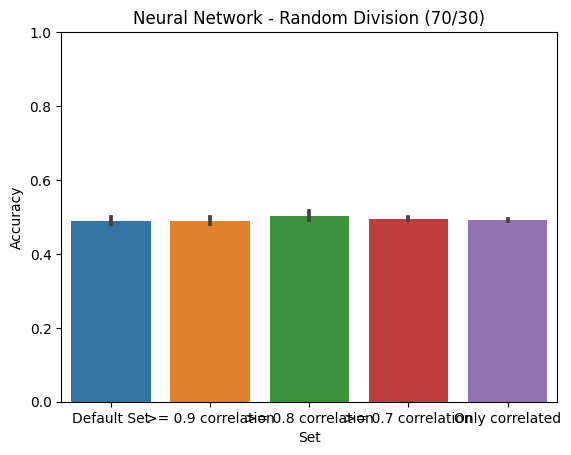

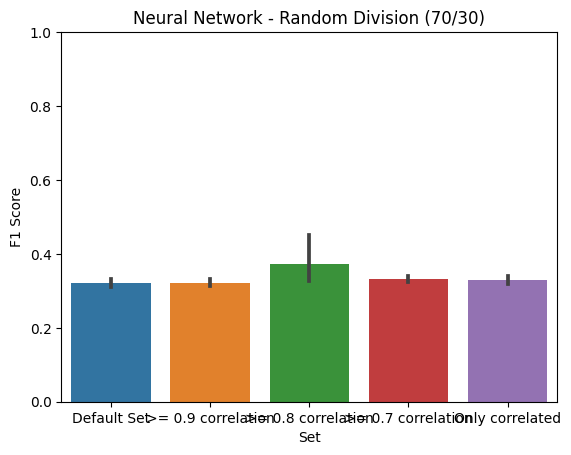

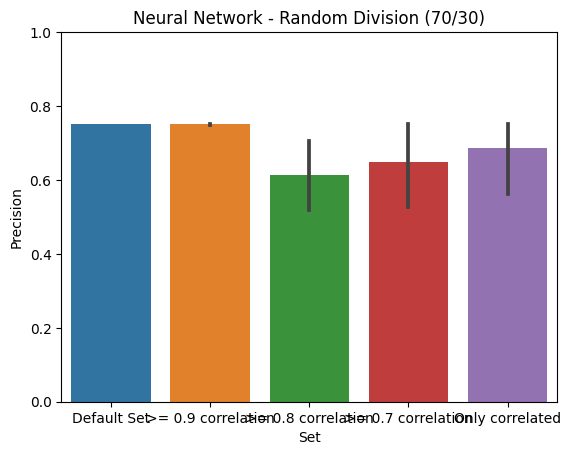

In [11]:
sets = {
    'Default Set': train_data,
    '>= 0.9 correlation': train_data_09,
    '>= 0.8 correlation': train_data_08,
    '>= 0.7 correlation': train_data_07,
    'Only correlated': train_data_nocorr,
    'Polynomial': train_data_poly,
    'Scaled': train_data_scaled,
    'Poly Scaled': train_data_poly_scaled
}


results = []

for (name, data_set) in sets.items():
    # Train the model
    for _ in range(5):  #running 5 times each
        neural_network = MLPClassifier(hidden_layer_sizes=(10, 20, 10), activation='logistic', solver='adam', alpha=0.0001, learning_rate_init=0.002)
        target_column = "is_claim"
        X = data_set.drop(target_column, axis=1)
        y = data_set[target_column]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        start_time = time.time()

        neural_network.fit(X_train, y_train)
        train_time = time.time() - start_time

        # Test the model
        start_time = time.time()
        y_pred = neural_network.predict(X_test)
        test_time = time.time() - start_time

        # Calculate evaluation metrics
        conf_matrix = confusion_matrix(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
        recall = recall_score(y_test, y_pred, average='weighted')
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')

        # Store the results
        results.append({
            'Set': name,
            'Confusion Matrix': conf_matrix,
            'Precision': precision,
            'Recall': recall,
            'Accuracy': accuracy,
            'F1 Score': f1,
            'Train Time': train_time,
            'Test Time': test_time
        })
# Convert the results into a DataFrame
results_df = pd.DataFrame(results)

# Display the results
print(results_df)

plt.ylim(0, 1)
plt.title("Neural Network - Random Division (70/30)")
sb.barplot(x='Set', y='Accuracy', data=results_df)
plt.show()

plt.ylim(0, 1)
plt.title("Neural Network - Random Division (70/30)")
sb.barplot(x='Set', y='F1 Score', data=results_df)
plt.show()

plt.ylim(0, 1)
plt.title("Neural Network - Random Division (70/30)")
sb.barplot(x='Set', y='Precision', data=results_df)
plt.show()

                   Set          Confusion Matrix  Precision    Recall   
0          Default Set      [[728, 0], [772, 0]]   0.750215  0.485333  \
1          Default Set      [[725, 0], [775, 0]]   0.750278  0.483333   
2          Default Set      [[732, 0], [768, 0]]   0.750144  0.488000   
3          Default Set      [[0, 757], [0, 743]]   0.750022  0.495333   
4          Default Set      [[0, 773], [0, 727]]   0.750235  0.484667   
5   >= 0.9 correlation      [[744, 0], [756, 0]]   0.750016  0.496000   
6   >= 0.9 correlation      [[0, 752], [0, 748]]   0.750002  0.498667   
7   >= 0.9 correlation      [[751, 0], [749, 0]]   0.750000  0.500667   
8   >= 0.9 correlation      [[0, 755], [0, 745]]   0.750011  0.496667   
9   >= 0.9 correlation      [[0, 754], [0, 746]]   0.750007  0.497333   
10  >= 0.8 correlation  [[341, 389], [324, 446]]   0.523742  0.524667   
11  >= 0.8 correlation      [[0, 773], [0, 727]]   0.750235  0.484667   
12  >= 0.8 correlation    [[52, 705], [33, 710]]   

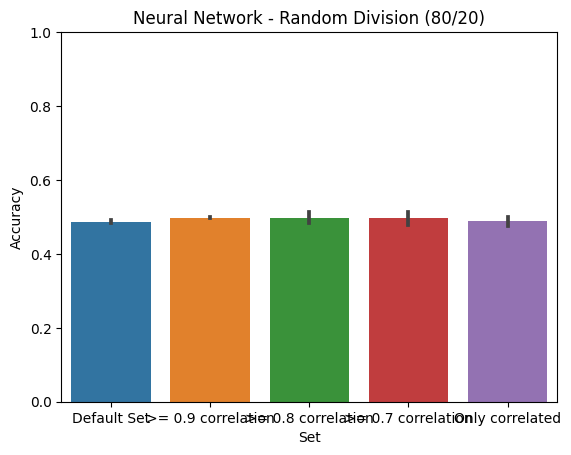

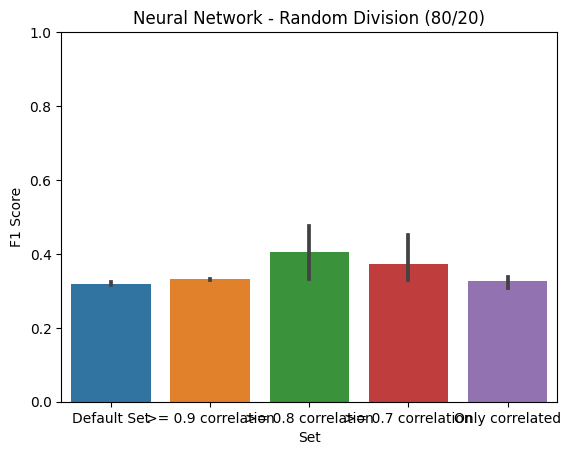

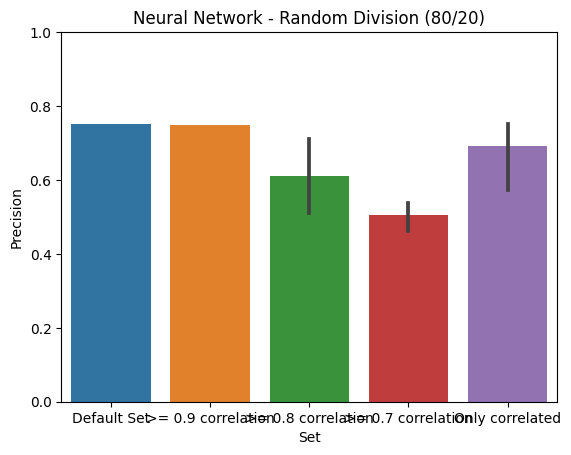

In [12]:
results = []

for (name, data_set) in sets.items():
    # Train the model
    for _ in range(5):  #running 5 times each
        neural_network = MLPClassifier(hidden_layer_sizes=(10, 20, 10), activation='logistic', solver='adam', alpha=0.0001, learning_rate_init=0.002)
        target_column = "is_claim"
        X = data_set.drop(target_column, axis=1)
        y = data_set[target_column]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        start_time = time.time()

        neural_network.fit(X_train, y_train)
        train_time = time.time() - start_time

        # Test the model
        start_time = time.time()
        y_pred = neural_network.predict(X_test)
        test_time = time.time() - start_time

        # Calculate evaluation metrics
        conf_matrix = confusion_matrix(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
        recall = recall_score(y_test, y_pred, average='weighted')
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')

        # Store the results
        results.append({
            'Set': name,
            'Confusion Matrix': conf_matrix,
            'Precision': precision,
            'Recall': recall,
            'Accuracy': accuracy,
            'F1 Score': f1,
            'Train Time': train_time,
            'Test Time': test_time
        })
# Convert the results into a DataFrame
results_df = pd.DataFrame(results)

# Display the results
print(results_df)

plt.ylim(0, 1)
plt.title("Neural Network - Random Division (80/20)")
sb.barplot(x='Set', y='Accuracy', data=results_df)
plt.show()

plt.ylim(0, 1)
plt.title("Neural Network - Random Division (80/20)")
sb.barplot(x='Set', y='F1 Score', data=results_df)
plt.show()

plt.ylim(0, 1)
plt.title("Neural Network - Random Division (80/20)")
sb.barplot(x='Set', y='Precision', data=results_df)
plt.show()

                   Set          Confusion Matrix  Precision    Recall   
0          Default Set    [[1249, 0], [1250, 0]]   0.750000  0.499800  \
1          Default Set    [[0, 1250], [0, 1249]]   0.750000  0.499800   
2          Default Set    [[1249, 0], [1249, 0]]   0.750000  0.500000   
3   >= 0.9 correlation  [[1222, 27], [1222, 28]]   0.504547  0.500200   
4   >= 0.9 correlation    [[1250, 0], [1249, 0]]   0.750000  0.500200   
5   >= 0.9 correlation    [[0, 1249], [0, 1249]]   0.750000  0.500000   
6   >= 0.8 correlation    [[1249, 0], [1250, 0]]   0.750000  0.499800   
7   >= 0.8 correlation  [[562, 688], [541, 708]]   0.508342  0.508203   
8   >= 0.8 correlation    [[1249, 0], [1249, 0]]   0.750000  0.500000   
9   >= 0.7 correlation    [[1249, 0], [1250, 0]]   0.750000  0.499800   
10  >= 0.7 correlation  [[20, 1230], [12, 1237]]   0.563234  0.503001   
11  >= 0.7 correlation  [[589, 660], [523, 726]]   0.526743  0.526421   
12     Only correlated    [[0, 1249], [0, 1250]]   

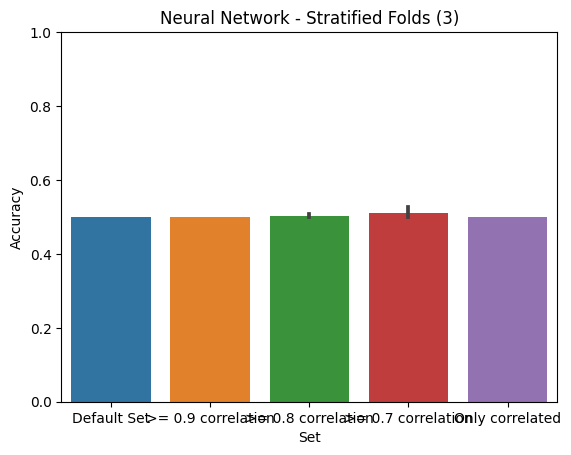

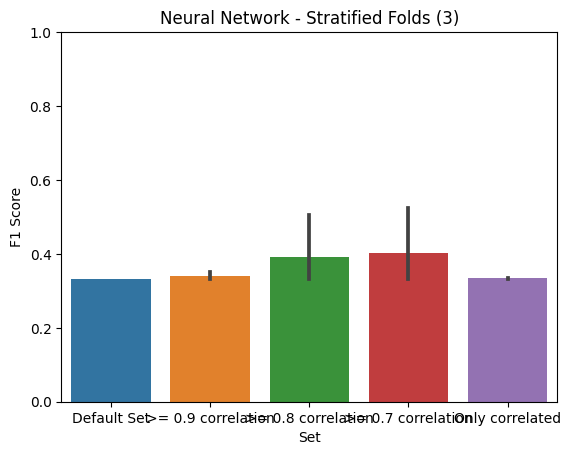

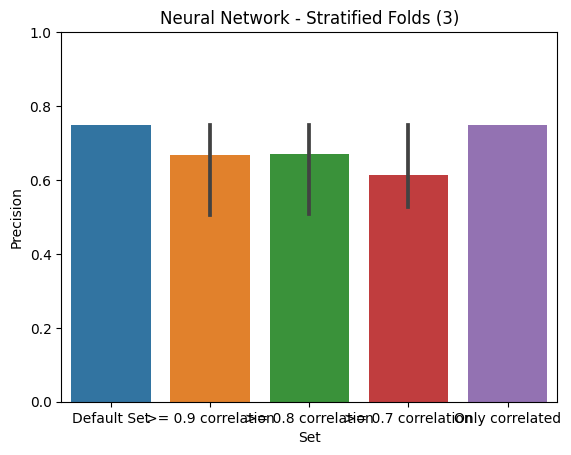

In [13]:
results = []
skf = StratifiedKFold(n_splits=3)

for (name, data_set) in sets.items():
    neural_network = MLPClassifier(hidden_layer_sizes=(10, 20, 10), activation='logistic', solver='adam', alpha=0.0001, learning_rate_init=0.002)
    target_column = "is_claim"
    X = data_set.drop(target_column, axis=1)
    y = data_set[target_column]
    for train_index, test_index in skf.split(X, y):
        # Train the model
        X_train, X_test = X.values[train_index], X.values[test_index]
        y_train, y_test = y.values[train_index], y.values[test_index]
        start_time = time.time()

        neural_network.fit(X_train, y_train)
        train_time = time.time() - start_time

        # Test the model
        start_time = time.time()
        y_pred = neural_network.predict(X_test)
        test_time = time.time() - start_time

        # Calculate evaluation metrics
        conf_matrix = confusion_matrix(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
        recall = recall_score(y_test, y_pred, average='weighted')
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')

        # Store the results
        results.append({
            'Set': name,
            'Confusion Matrix': conf_matrix,
            'Precision': precision,
            'Recall': recall,
            'Accuracy': accuracy,
            'F1 Score': f1,
            'Train Time': train_time,
            'Test Time': test_time
        })
# Convert the results into a DataFrame
results_df = pd.DataFrame(results)

# Display the results
print(results_df)

plt.ylim(0, 1)
plt.title("Neural Network - Stratified Folds (3)")
sb.barplot(x='Set', y='Accuracy', data=results_df)
plt.show()

plt.ylim(0, 1)
plt.title("Neural Network - Stratified Folds (3)")
sb.barplot(x='Set', y='F1 Score', data=results_df)
plt.show()

plt.ylim(0, 1)
plt.title("Neural Network - Stratified Folds (3)")
sb.barplot(x='Set', y='Precision', data=results_df)
plt.show()

In [14]:
from sklearn.model_selection import GridSearchCV


def grid_search_analysis(target, parameters, model, search_datasets, datasets_names):
    search_results = []
    for dataset in search_datasets:
        X = dataset.drop(target, axis=1)
        y = dataset[target]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        grid_search = GridSearchCV(model, param_grid=parameters, cv=5, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_params = grid_search.best_params_
        y_pred = grid_search.predict(X_test)
        print(best_params)

        conf_matrix_metrics = confusion_matrix(y_test, y_pred)
        precision_metrics = precision_score(y_test, y_pred, average='weighted', zero_division=1)
        recall_metrics = recall_score(y_test, y_pred, average='weighted')
        accuracy_metrics = accuracy_score(y_test, y_pred)
        f1_metrics = f1_score(y_test, y_pred, average='weighted')

        # Store the search_results
        search_results.append({
            'Confusion Matrix': conf_matrix_metrics,
            'Precision': precision_metrics,
            'Recall': recall_metrics,
            'Accuracy': accuracy_metrics,
            'F1 Score': f1_metrics,
        })
    for i, result in enumerate(search_results):
        # Create a heatmap of the confusion matrix
        sb.heatmap(result['Confusion Matrix'], annot=True, cmap='Blues')

        # Add labels and title to the plot
        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        plt.title(f'Confusion Matrix for ' + datasets_names[i])

        # Show the plot
        plt.show()
    metrics = ['Precision', 'Recall', 'Accuracy', 'F1 Score']
    for metric in metrics:
        # Extract the metric values for each dataset
        values = [result[metric] for result in search_results]

        # Create a bar plot to compare the metric values
        sb.barplot(x=datasets_names, y=values)

        # Add labels and title to the plot
        plt.ylim(0, 1)
        plt.xlabel('Dataset')
        plt.ylabel(metric)
        plt.title(f'{metric} comparison across search_datasets')
        # Show the plot
        plt.show()

We can conclude that the results didn't change much with the different sets and tweaks made in the neural network. Still, the `Only correlated` set performs well in the 80/20 random division (highest precision).

There is still some possible work in the data to improve the overall results.

### Now we will use the GridSearchCV component of the sklearn package in order to find out the parameters combination that produces the best outcome for every classifier

### Furthermore, we also use some plots to make the comparison easier and more intuitive

In [15]:
names = ['Train Data', 'Train Data 07', 'Train Data 08', 'Train Data 09', 'Only Correlated', 'Polynomial', 'Scaled', 'Poly Scaled']
datasets = [train_data, train_data_07, train_data_08, train_data_09, train_data_nocorr, train_data_poly, train_data_scaled, train_data_poly_scaled]
target_column = "is_claim"

### Neural Network

Regarding the Neural Network model:

{'activation': 'tanh', 'alpha': 0.001, 'early_stopping': False, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'max_iter': 400, 'solver': 'sgd'}
{'activation': 'tanh', 'alpha': 0.001, 'early_stopping': False, 'hidden_layer_sizes': (100, 100), 'learning_rate': 'adaptive', 'max_iter': 400, 'solver': 'sgd'}
{'activation': 'relu', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'max_iter': 400, 'solver': 'adam'}
{'activation': 'relu', 'alpha': 0.001, 'early_stopping': True, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 600, 'solver': 'adam'}
{'activation': 'tanh', 'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 400, 'solver': 'sgd'}


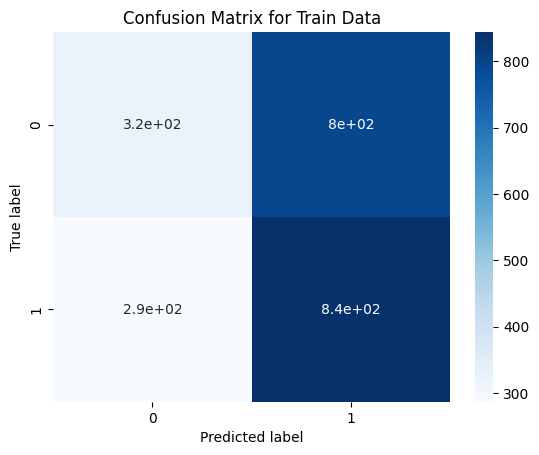

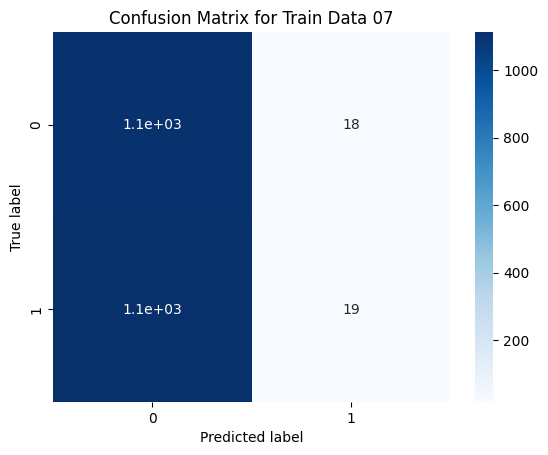

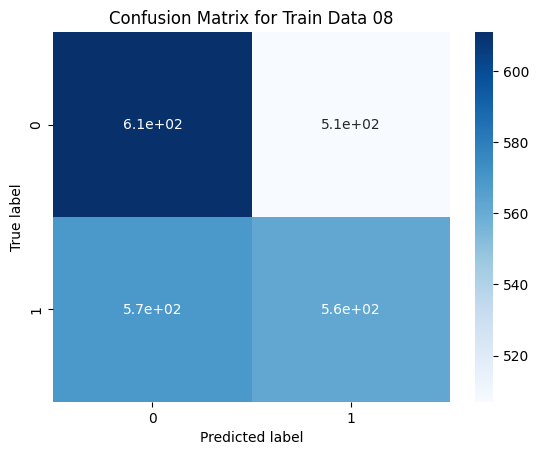

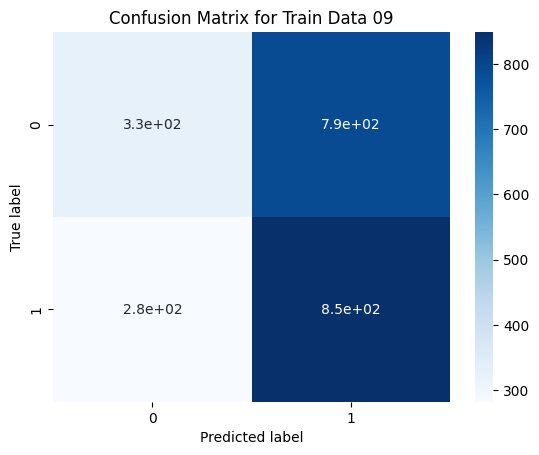

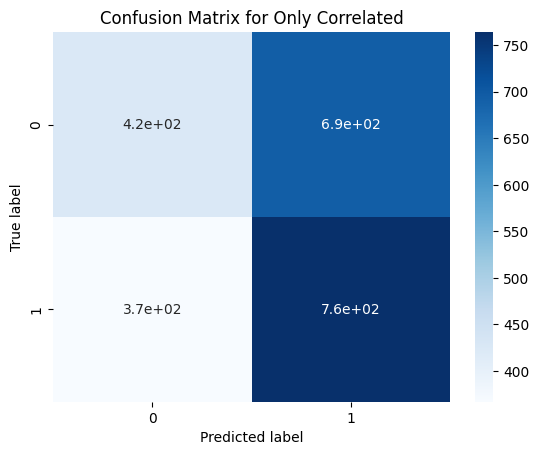

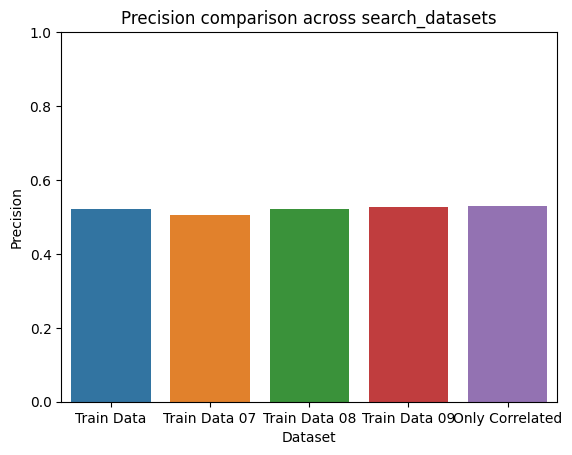

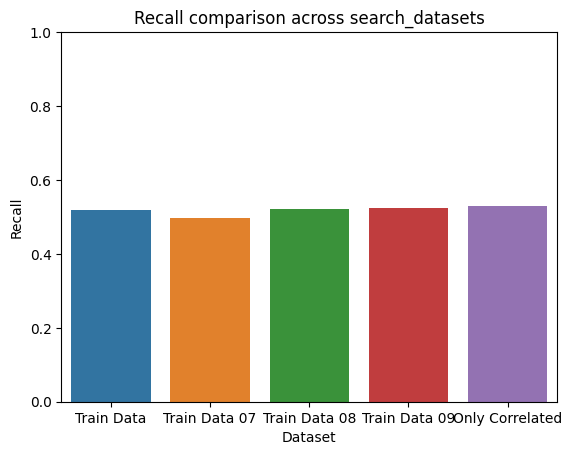

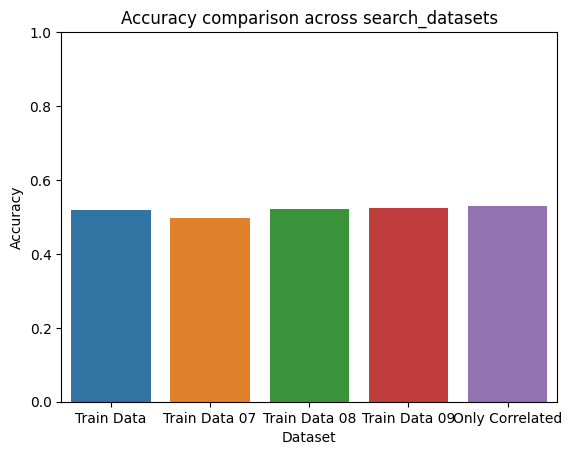

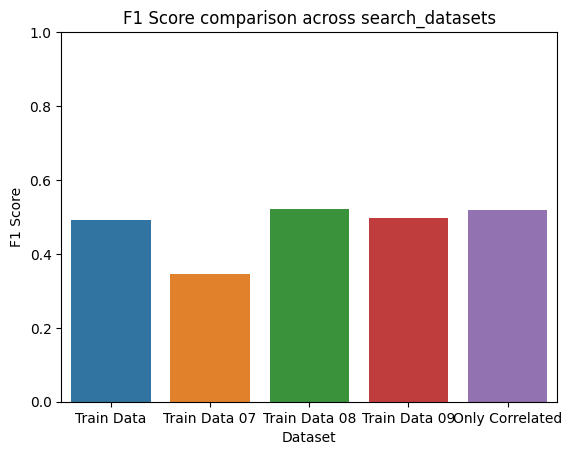

In [16]:
params = {
    'hidden_layer_sizes': [(100,), (50, 100), (50, 50, 100), (100, 100)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [200, 400, 600],
    'early_stopping': [True, False]
}

grid_search_analysis(target_column, params, MLPClassifier(), datasets, names)

### Decision Tree

Regarding the Decision Tree model:

{'criterion': 'entropy', 'max_depth': 40, 'max_features': 48, 'min_samples_leaf': 0.1, 'min_samples_split': 0.6, 'splitter': 'best'}
{'criterion': 'gini', 'max_depth': 640, 'max_features': 3, 'min_samples_leaf': 0.1, 'min_samples_split': 0.3, 'splitter': 'best'}
{'criterion': 'gini', 'max_depth': 10, 'max_features': 5, 'min_samples_leaf': 0.1, 'min_samples_split': 0.2, 'splitter': 'best'}
{'criterion': 'entropy', 'max_depth': 20, 'max_features': 6, 'min_samples_leaf': 0.1, 'min_samples_split': 0.1, 'splitter': 'best'}
{'criterion': 'entropy', 'max_depth': 640, 'max_features': 4, 'min_samples_leaf': 0.1, 'min_samples_split': 0.1, 'splitter': 'best'}


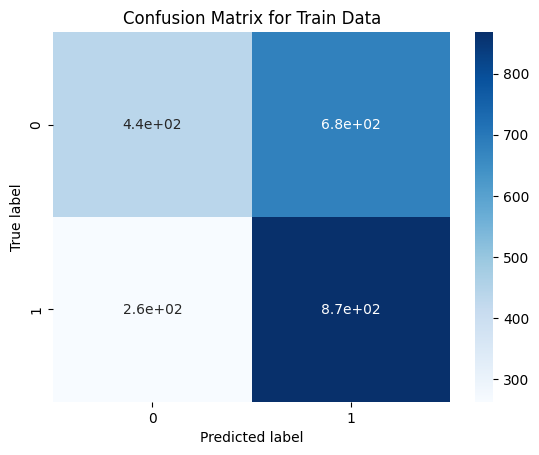

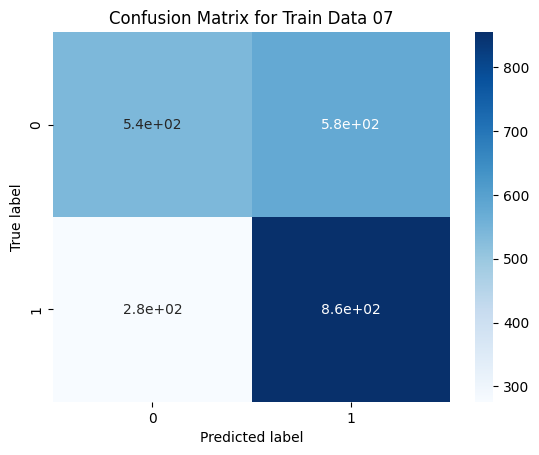

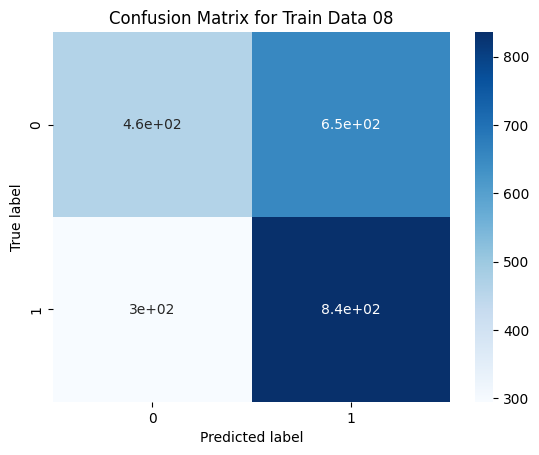

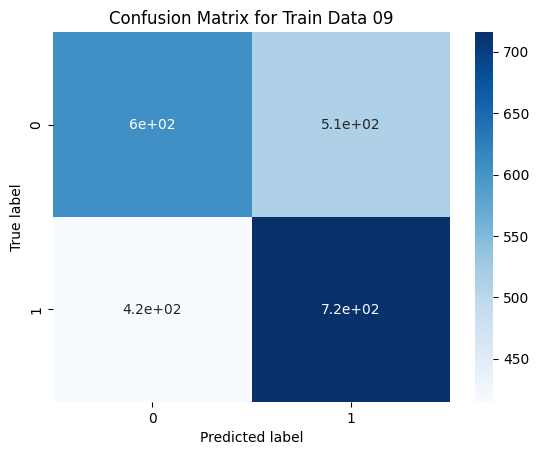

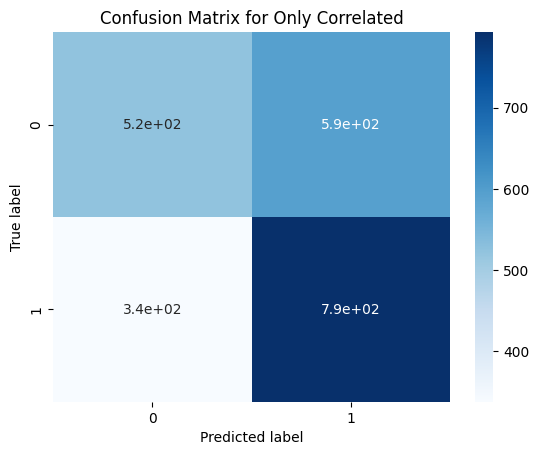

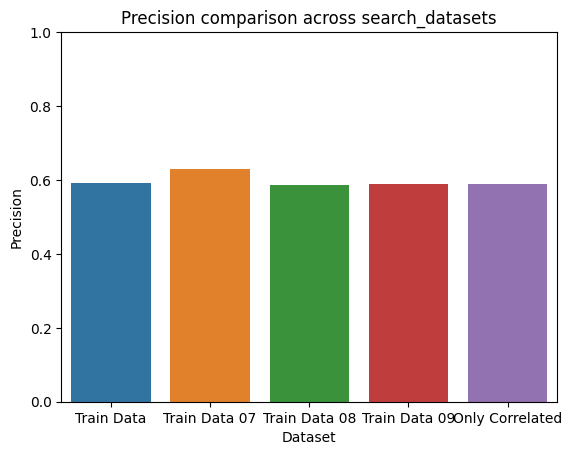

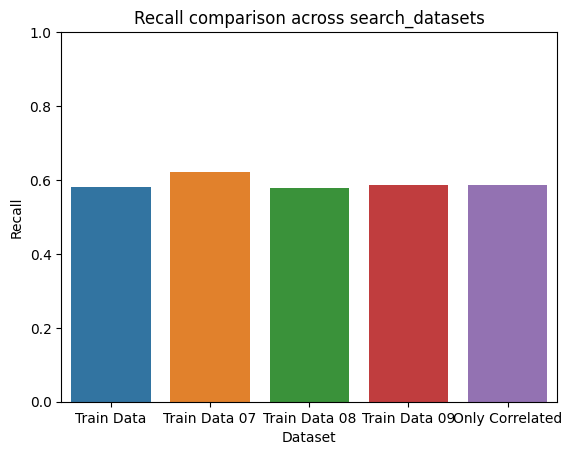

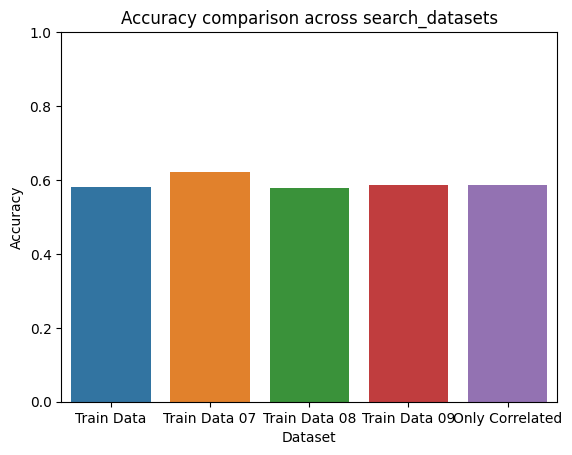

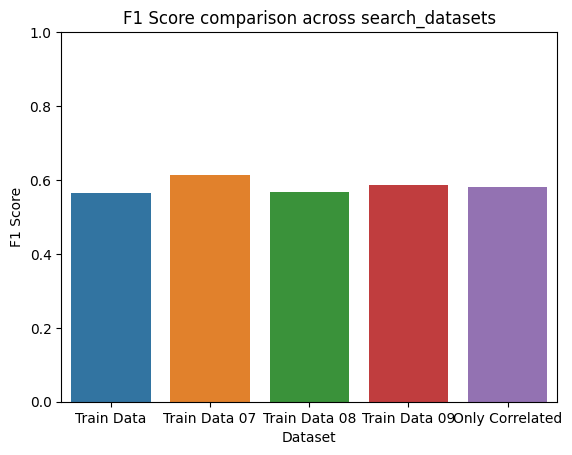

In [17]:
params = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [1, 2, 5, 10, 20, 40, 80, 160, 320, 640, None],
    'min_samples_split': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'min_samples_leaf': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    'max_features': [None] + [x for x in range(1, len(train_data.columns))]
}
grid_search_analysis(target_column, params, DecisionTreeClassifier(), datasets, names)
# Best params results:
# {'criterion': 'entropy', 'max_depth': 20, 'max_features': 32, 'min_samples_leaf': 0.1, 'min_samples_split': 0.5, 'splitter': 'best'}
# {'criterion': 'entropy', 'max_depth': 20, 'max_features': 3, 'min_samples_leaf': 0.1, 'min_samples_split': 0.6, 'splitter': 'best'}
# {'criterion': 'entropy', 'max_depth': 640, 'max_features': 5, 'min_samples_leaf': 0.1, 'min_samples_split': 0.6, 'splitter': 'best'}
# {'criterion': 'gini', 'max_depth': 10, 'max_features': 6, 'min_samples_leaf': 0.1, 'min_samples_split': 0.2, 'splitter': 'best'}

Based on the results obtained, it appears that all sets except for the `Only Correlated` set have opted for using the Gini criterion. This criterion focuses on identifying the degree of impurity in the data, which is appropriate given the presence of numerous irrelevant features. On the other hand, the `Only Correlated` set has chosen to use the Entropy criterion, which is more concerned with the amount of information gained from a split. This is logical as this set only contains useful features.

The remaining parameters are primarily influenced by the size of the data sets. The default set, which is larger, requires more search and hence more computational resources. In contrast, the smaller 70% data set does not require as much computational effort as it has fewer data.

### K-Nearest Neighbors

Regarding the K-Nearest Neighbors model:

{'algorithm': 'auto', 'leaf_size': 10, 'metric': 'manhattan', 'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}
{'algorithm': 'auto', 'leaf_size': 10, 'metric': 'manhattan', 'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}
{'algorithm': 'auto', 'leaf_size': 10, 'metric': 'manhattan', 'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}
{'algorithm': 'auto', 'leaf_size': 10, 'metric': 'manhattan', 'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}
{'algorithm': 'auto', 'leaf_size': 10, 'metric': 'manhattan', 'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}


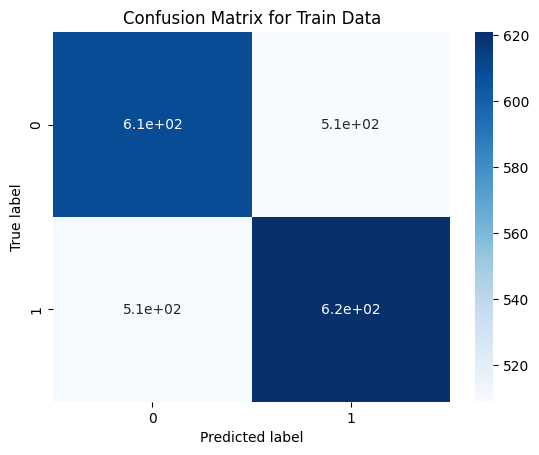

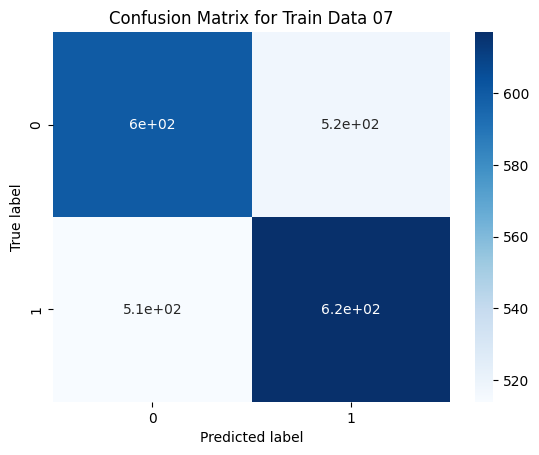

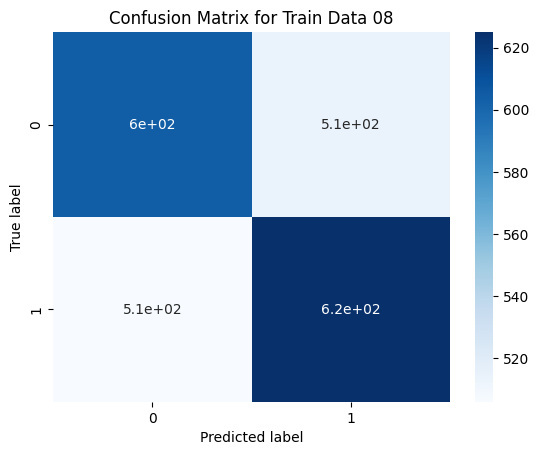

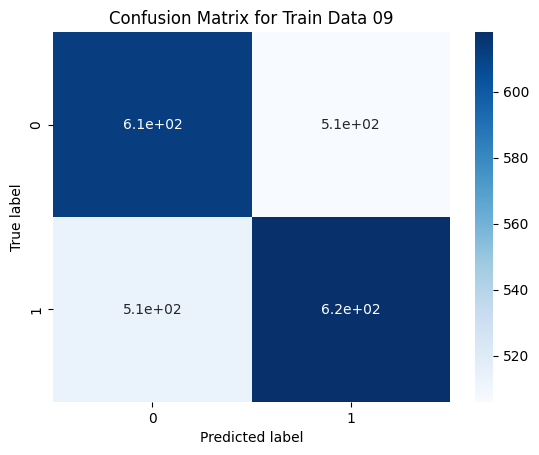

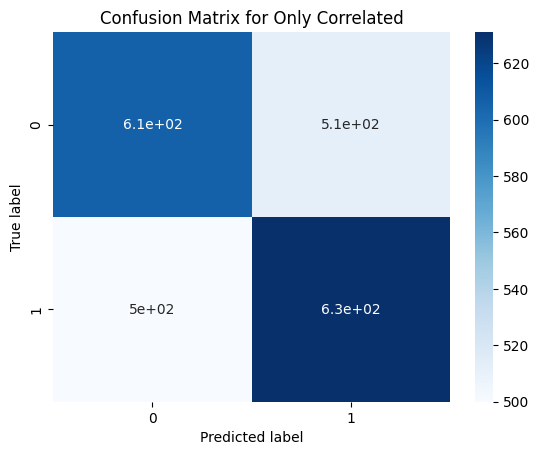

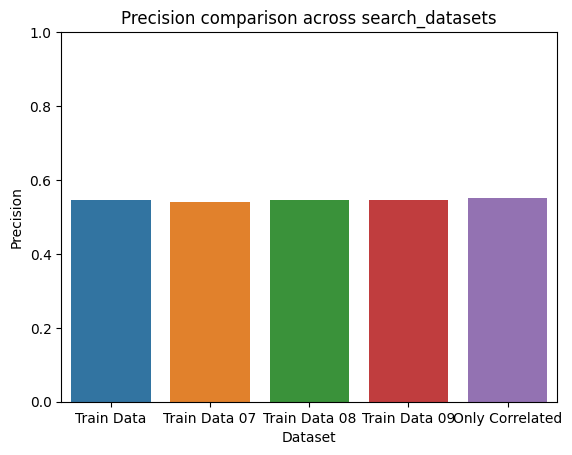

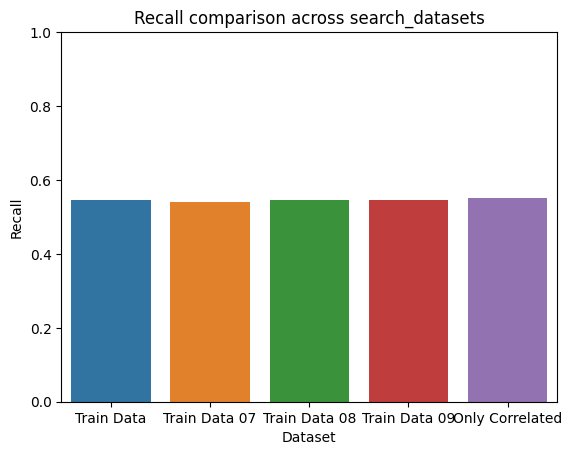

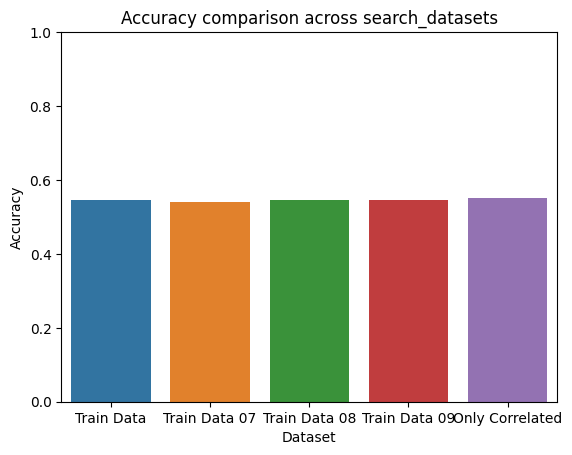

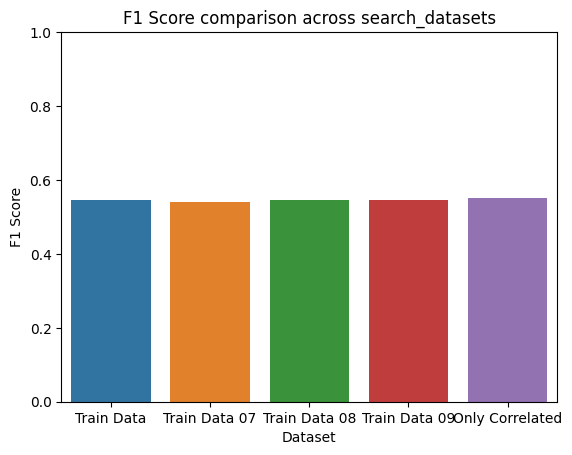

In [18]:
params = {
    'n_neighbors': [1, 3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 20, 30, 40, 50],
    'p': [1, 2],
    'metric': ['euclidean', 'manhattan', 'chebyshev']
}

grid_search_analysis(target_column, params, KNeighborsClassifier(), datasets, names)

### Support Vector Machine

Regarding the Support Vector Machine model:

In [ ]:
params = {
    'C': [0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4, 5],
    'gamma': ['scale', 'auto'],
    'coef0': [0, 1, 2, 3],
    'shrinking': [True, False],
    'tol': [1e-3, 1e-4, 1e-5],
    'max_iter': [-1, 1000, 2000, 5000],
    'decision_function_shape': ['ovr', 'ovo']
}

grid_search_analysis(target_column, params, SVC(), datasets, names)